In [ ]:
#@title Execute this block to start importing the libraries (**HuggingFace Transformer** and **langchain**) and download 2024-25 HK Financial Report: https://www.budget.gov.hk/2024/eng/pdf/e_budget_speech_2024-25.pdf

# Download the documents
!mkdir data
!wget https://www.budget.gov.hk/2024/eng/pdf/e_budget_speech_2024-25.pdf
!mv e_budget_speech_2024-25.pdf data

!pip install -q flash-attn
!pip install -qU pypdf
!pip install -q langchain_community
!pip install -q langchain_huggingface

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.vectorstores import InMemoryVectorStore

# Wrap the output text
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# Show the LLM reply in the textarea box
import ipywidgets as widgets
display(HTML("<style>textarea, input { font-family: Courier New;}</style>"))


# Output the LLM reply only
def extractReply(output):
  delim = '[/INST]'
  return output[output.find(delim) + len(delim) + 1 : ]


def displayLLMOutput(llmOutput):
  text = widgets.Textarea(
      value=extractReply(llmOutput),
      description='LLM Reply:',
      disabled=False,
      layout=widgets.Layout(height="200px", width="auto"),

  )

  display(text)

In [ ]:
#@title Load the LLM (Large Language Model)

llmModel = "microsoft/Phi-3-mini-4k-instruct" # @param ["TheBloke/Mistral-7B-Instruct-v0.2-GPTQ"] {allow-input: true}

model_name = llmModel
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Parameters to control LLM's response generation
generation_args = {
    "max_new_tokens": 512,     # Maximum length of the response
    "return_full_text": False,      # Only return the generated text
}

def query(messages):
  """Sends a conversation history to the AI assistant and returns the answer.

  Args:
    messages (list): A list of dictionaries, each with "role" and "content" keys.

  Returns:
    str: The answer from the AI assistant.
  """

  output = pipe(messages, **generation_args)
  return output[0]['generated_text']


### Ask the question to LLM directly without your own or latest data

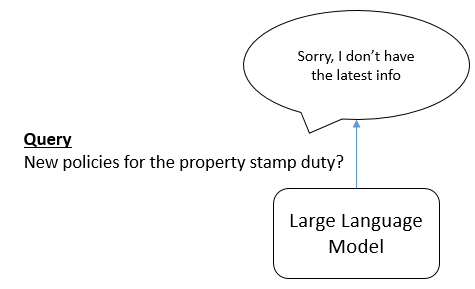

In [ ]:
#@title Input the question to LLM

question = "What's the new policies for the property stamp duty in the HK Financial Budget?" # @param {type:"string"}

messages = [
    {"role": "system", "content": "You are a helpful digital assistant. Please provide safe, ethical and accurate information to the user."},
    {"role": "user", "content": question}
]
result = query(messages)

# prompt (no context)
displayLLMOutput(result)


# RAG (Retrieval Augmented Generation)
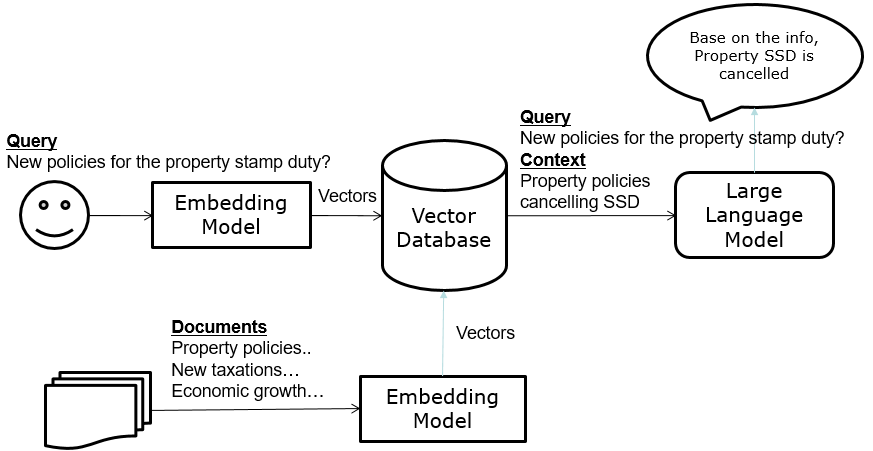

Based on Shaw Talebi article: https://towardsdatascience.com/how-to-improve-llms-with-rag-abdc132f76ac


### The Embedding Model convert text to vector representation.

*   Massive Text Embedding Benchmark (MTEB) Leaderboard : https://huggingface.co/spaces/mteb/leaderboard


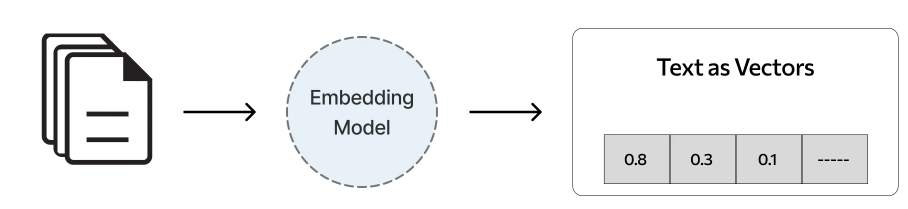

In [ ]:
#@title Choose an embedding model (vectorize the text)

embeddingModelName = 'BAAI/bge-small-en-v1.5' # @param ["BAAI/bge-small-en-v1.5", "paraphrase-MiniLM-L6-v2" ] {allow-input: true}
embeddingModel = HuggingFaceEmbeddings(model_name=embeddingModelName)

In [ ]:
#@title Print the input embedding vector

question = "What's the new policies for the property stamp duty in the HK Financial Budget?" # @param {type:"string"}

embeddings = embeddingModel.embed_query(question)
print("Vector size: {}".format(len(embeddings)))
print(embeddings)

### Read the pdf docs, convert them to vector (by embedding model) and store into a Vector DB

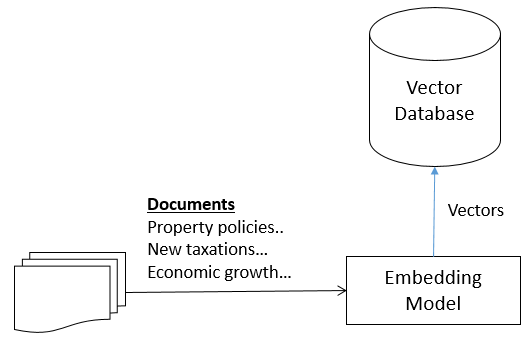

In [ ]:
#@title Load the pdf, convert them to vector (by text embedding model) and store into a LangChain in-memory Vector DB

loader = PyPDFLoader("data/e_budget_speech_2024-25.pdf")
pages = loader.load_and_split()
vector_store = InMemoryVectorStore.from_documents(pages, embeddingModel)

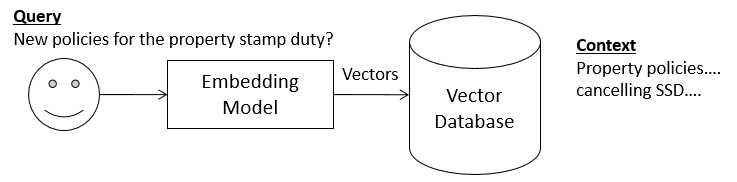

### Set up the search function and look up relevant content from the embedding


* **top_k**: the number of chunks (documents) returned from the query

In [ ]:
docs = vector_store.similarity_search(question, k=2)

context = ''
for doc in docs:
    context += doc.page_content[:3000]

print(context)

### Construct the prompt with the context and then query LLM

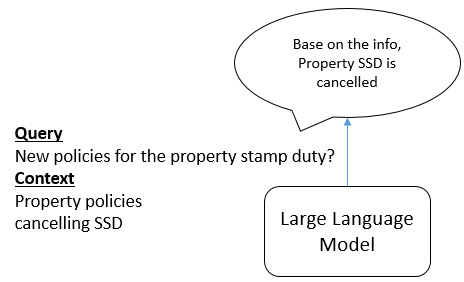

In [ ]:
#@title Query LLM with the context looked up from the embedding documents

messages = [
    {"role": "system", "content": "You are a helpful digital assistant. Please provide safe, ethical and accurate information to the user."},
    {"role": "user", "content": question + "  Use the following context: \n\n" + context}
]
result = query(messages)

# prompt (no context)
displayLLMOutput(result)